<a href="https://colab.research.google.com/github/IRClichtR/Stockprice_prediction/blob/main/stockprice_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predictor** -- a small introduction to LSTM machine learning technic

Some references to contruct introductory text:


* https://www.bioinf.jku.at/publications/older/2604.pdf : LSTM paper from Hochreiter & Schmidhuber
* https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/ : Explain what is LSTM
* https://www.ibm.com/topics/recurrent-neural-networks : Explane what is RNN
* https://www.youtube.com/watch?v=qg4PchTECck : gradient descent in a nutshell
* https://rtavenar.github.io/deep_book/fr/content/fr/loss.html : fonction de cout introduction

On stock market prices:
* https://patrickalphac.medium.com/stock-api-landscape-5c6e054ee631 : Some API in financial marcket information retrieving


**What are training set and test set**

* https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7
* https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets

**Avoid data leakage and overfitting**
* https://towardsdatascience.com/data-leakage-in-machine-learning-how-it-can-be-detected-and-minimize-the-risk-8ef4e3a97562

**Mean squared error**
* https://en.wikipedia.org/wiki/Mean_squared_error



In [ ]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import requests
import json
from google.colab import drive
from google.colab import userdata

**Declare a data generator class**

Loaded data from Kaggle
Shape of the data (12074, 5)
         Date    Open    High     Low   Close
0  1970-01-02  3.1254  3.1254  3.0920  3.1254
1  1970-01-05  3.1254  3.1339  3.1004  3.1254
2  1970-01-06  3.1254  3.1588  3.1087  3.1588
3  1970-01-07  3.1671  3.2503  3.1671  3.2337
4  1970-01-08  3.2254  3.2254  3.1838  3.2254


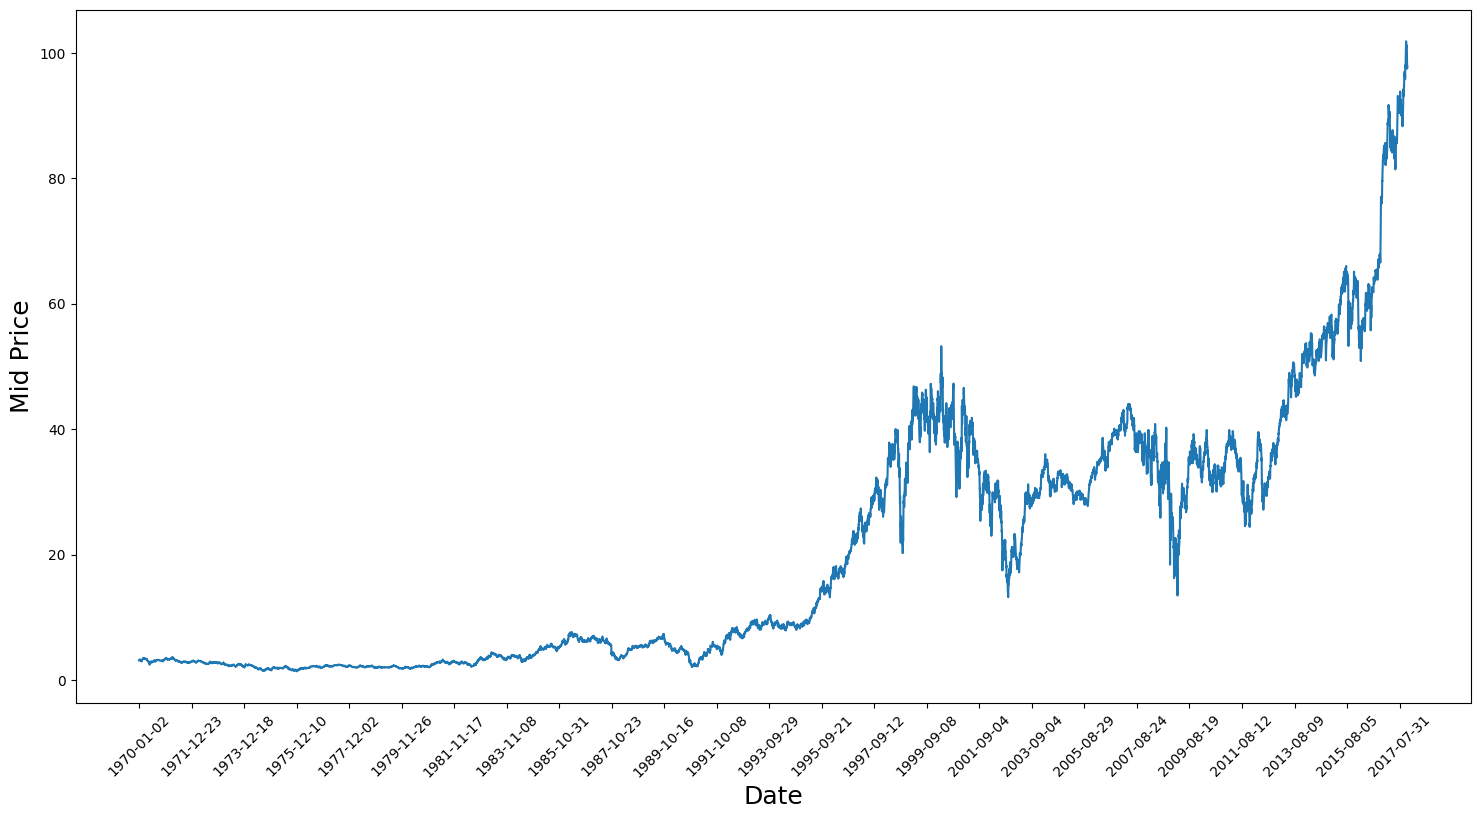

MSE error for standard averaging: 0.00501


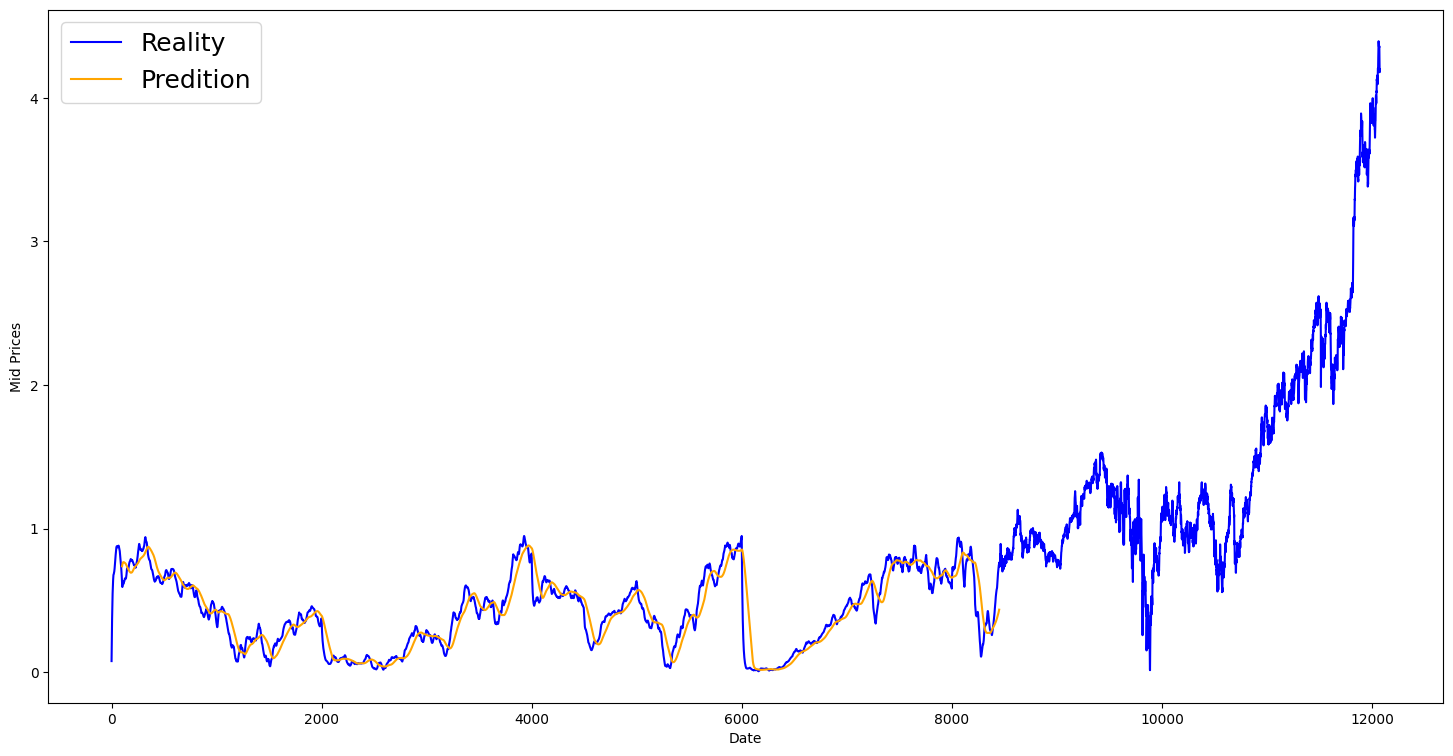

In [ ]:
# This function takes the json data obtained from the website
# and put it into a pandas DataFrame

def put_in_df(data_json):
  if 'Time Series (Daily)' in data_json:
    time_series_data = data_json['Time Series (Daily)']
    df = pd.DataFrame.from_dict(time_series_data, orient='index')
    df.rename(columns={
        '1. open': 'Open',
        '2. high': 'High',
        '3. low': 'Low',
        '4. close': 'Close',
        '5. adjusted close': 'Adjusted Close',
        '6. volume': 'Volume',
        '7. dividend amount': 'Dividend Amount',
        '8. split coefficient': 'Split Coefficient'
    }, inplace=True)
    df.index = pd.to_datetime(df.index)
    df.index.name = 'Date'
    df = df.apply(pd.to_numeric, errors='coerce')
    return df
  else:
    print('Error create df')
    return None


# function that uses the API to get all data from the selected symbol

def get_data(symbol, API_key, data_file):

  endpoint = 'https://www.alphavantage.co/query'
  params = {
      'function': 'TIME_SERIES_DAILY_ADJUSTED',
      'symbol' :  symbol,
      'apikey' :  API_key,
      'outputsize' : 'full'
  }
  response = requests.get(endpoint, params=params)
  if response.status_code == 200:
    data_json = response.json()
    if data_json.find('This is a premium endpoint'):
      print('Premium data not available')
      return None
    else:
      df = put_in_df(data_json)
      df.to_csv(data_file)
      print("data saved to:", data_file)
      return df
  else:
    print('Error', response.status_code)
    return None


# function that creates and fills data csv file from json request response
# and returns the dataframe used to create the csv file

def data_frame_create(API_key, symbol, data_file):
  if not os.path.exists(data_file):
    df = get_data(symbol, API_key, data_file)
  else:
    print('File already exists. Loading data from .csv')
    df = pd.read_csv(data_file)

  df.sort_values('Date')
  return df


def mount_file_in_drive():
  mount_flag = os.path.isdir('/content/drive/MyDrive')
  if not mount_flag:
    drive.mount('/content/drive')


def display_plot(df):
  plt.figure(figsize = (18,9))
  plt.plot(range(df.shape[0]), (df['Low']+df['High'])/2.0)
  plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
  plt.xlabel('Date',fontsize=18)
  plt.ylabel('Mid Price',fontsize=18)
  plt.show()


def smooth_data(data, smoothing_size):
  data_len = len(data)
  for di in range(0, data_len, smoothing_size):
    end = min(di + smoothing_size, data_len)
    if end > di:
      current_slice = data[di:end, :]
      if current_slice.size > 0:
        scaler.fit(current_slice)
        data[di:end, :] = scaler.transform(current_slice)
      else:
        print("Warning: Slice's empty, skipping scaling")
    else:
      print("Warning: Invalid slice, skipping scaling")
  remaining_slice_start = di + smoothing_size
  if remaining_slice_start < data_len:
    remaining_slice = data[remaining_slice_start:, :]
    if remaining_slice.size > 0:
      scaler.fit(remaining_slice)
      data[remaining_slice_start:, :] = scaler.transform(remaining_slice)
    else:
      print("Warning: remaining slice is empty, skipping scaling")

def display_average_prediction_plot(df, all_mid_data, std_avg_preditions):
  plt.figure(figsize = (18,9))
  plt.plot(range(df.shape[0]), all_mid_data,color='b',label='Reality')
  plt.plot(range(window_size,N), std_avg_predictions,color='orange',label='Predition')
  plt.xlabel('Date')
  plt.ylabel('Mid Prices')
  plt.legend(fontsize=18)
  plt.show()

##################### MAIN #####################
if __name__ == "__main__":
  method = 'kaggle'
  mount_file_in_drive()
  if method == 'alphavantage':
    API_key =  userdata.get('API_key') # retrieved from Alpha Vantage support https://www.alphavantage.co/support/#api-key
    symbol = 'JPM'
    data_file = '/content/drive/MyDrive/stockpricedata/JPM_data.csv'
    df = data_frame_create(API_key, symbol, data_file)
    if df == None:
      print('Error dataframe is not correct: check entrypoint')
      exit(1)
  else:
    df = pd.read_csv('/content/drive/MyDrive/stockpricedata/jpm.us.txt',delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from Kaggle')
    print('Shape of the data', df.shape)
    print(df.head())

  # display initial plot to ensure everything is alright
  display_plot(df)
  #
  #----- df created ok -----#


  # Calculate the mid prices
  high_prices = df.loc[:,'High'].to_numpy()
  low_prices = df.loc[:,'Low'].to_numpy()
  mid_prices = (high_prices + low_prices) / 2.0
  # print('High Prices =', high_prices, '| Low prices =', low_prices, ' Average = ', mid_prices)

  # define test and validation sets
  total_rows = df.shape[0]
  split_index = int(total_rows * 0.7) # use a 70/30 ratio for robust testing
  train_data = mid_prices[:split_index]
  test_data = mid_prices[split_index:]

  # Normalize data
  scaler = MinMaxScaler()
  train_data = train_data.reshape(-1, 1)
  test_data = test_data.reshape(-1, 1)

  # Smooth data
  smooth_data(train_data, 2000) # Smooth train_data to avoid overfitting
  train_data = train_data.reshape(-1) #reshaping the data
  test_data = scaler.transform(test_data).reshape(-1) # don't use smooth_data(test_data, 2000) # Don't smooth the test_data in the same way to avoid data leakage


  #----- EMA prediction model -----#
  #
  # Exponential averag smoothing only for training data to avoid overfitting
  EMA = 0.0
  gamma = 0.1
  train_data_len = len(train_data)
  for i in range(0, train_data_len):
    EMA = gamma*train_data[i] + (1-gamma)*EMA
    train_data[i] = EMA

  # Variable used for visualization
  all_mid_data = np.concatenate([train_data, test_data], axis=0)

  window_size = 100
  N = train_data.size
  std_avg_predictions = []
  std_avg_x = []
  mse_errors = []

  for pred_idx in range(window_size, N):
    if pred_idx >= N:
      date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
      date = df.loc[pred_idx, 'Date']
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

  print("MSE error for standard averaging: %.5f" % (0.5 * np.mean(mse_errors)))

  # Display deviation between prediction and reality
  display_average_prediction_plot(df, all_mid_data, std_avg_predictions)

  # WARNING :
  # This approach cannot go further than 1 day ahead
  # for any prediction more than 1 day ahead the prediction is the same
  # that is the reason why we need better approach
  #----- End of EMA Approach -----#

  #----- Try an LSTM approach -----#
  #----- (to be continued) -----#






